In [45]:
# Import all libraries
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
import pandas as pd
import glob 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pickle
import en_core_web_sm
nlp = en_core_web_sm.load()
import re

In [46]:
# Data Pre-processing
def handle_emojis(tweet):
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet) # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)           # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)                        # Love -- <3, :*   
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)', ' EMO_POS ', tweet)              # Wink -- ;-), ;), ;-D, ;D, (;,  (-;  
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)       # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)               # Cry -- :,(, :'(, :"(     
    return tweet

def is_valid_word(word):
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)     # Check if word begins with an alphabet
    
def preprocess_word(word):
    word = word.strip('\'"?!,.():;')                                       # Remove punctuation
    word = re.sub(r'(.)\1+', r'\1\1', word)                                # Convert more than 2 letter repetitions to 2 letter 
    word = re.sub(r'(-|\')', '', word)                                     # Remove - & '
    return word

def preprocess_tweet(tweet):
  processed_tweet = []
  tweet = tweet.lower()                                                    # Convert to lower case
  tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', tweet)           # Convert to lower case
  tweet = re.sub(r'@[\S]+', ' ', tweet)                                    # Replace @handle with the word USER_MENTION
  tweet = re.sub(r'#', '', tweet)                                          # Replaces #hashtag with hashtag
  tweet = re.sub(r'\brt\b', '', tweet)                                     # Remove RT (retweet)
  tweet = re.sub(r'\.{2,}', ' ', tweet)                                    # Replace 2+ dots with space 
  tweet = tweet.strip(' "\'')                                              # Strip space, " and ' from tweet
  tweet = handle_emojis(tweet)                                             # Replace emojis with either EMO_POS or EMO_NEG
  tweet = re.sub(r'\s+', ' ', tweet)                                       # Replace multiple spaces with a single space 
  words = tweet.split()
  for word in words:
    word = preprocess_word(word)
    if is_valid_word(word):
      processed_tweet.append(word)
  clean_tweet = ' '.join(processed_tweet)
  return clean_tweet

In [47]:
df = pd.read_csv('Dataset.csv') # Read csv file
df['Category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)                                 # Category to Id dictionary
id_to_category = dict(category_id_df[['Category_id', 'Category']].values)    # Id to Category dictionary
df.shape

(35514, 4)

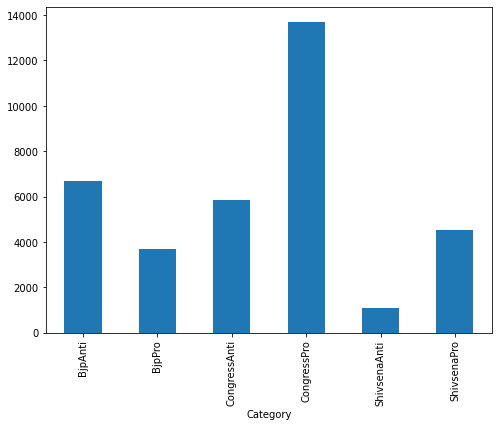

In [48]:
# Visualization of dataset
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Tweets.count().plot.bar(ylim=0)
plt.show()

In [49]:
clean_tweet = []
for i in range(df.shape[0]):
  clean_tweet.append(preprocess_tweet(df['Tweets'][i]))
df['Clean_tweets'] = clean_tweet
print(df['Tweets'][10])
print(df['Clean_tweets'][10])

Riot Rewards: BJP's Vote Share Increases After Hindu-Muslim Clashes Riot Rewards: BJP's Vote Share Increases After Hindu-Muslim Clashes. A 1% increase in the number of riots in a district improves BJP's vote share by 4.4%. https://t.co/lbKqsRyVUz

riot rewards bjps vote share increases after hindumuslim clashes riot rewards bjps vote share increases after hindumuslim clashes a increase in the number of riots in a district improves bjps vote share by


In [50]:
X_train, X_test, y_train, y_test = train_test_split(df['Clean_tweets'], df['Category_id'], train_size = 0.8, random_state = 0)  # Split dataset into train and test set
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=3, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
X_train = tfidf.fit_transform(X_train).toarray()   # Convert train data to tfidf encoding  
X_test = tfidf.transform(X_test).toarray()         # Convert test data to tfidf encoding  
print(X_train.shape)
print(X_test.shape)

(28411, 40051)
(7103, 40051)


In [51]:
# Function to display result
def display_result(y_test, y_pred):
  conf_mat = confusion_matrix(y_test, y_pred,labels=[0,1,2,3,4,5])
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, annot=True, fmt='d',
              xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values, cmap = plt.cm.Blues)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()
  print(precision_recall_fscore_support(y_test, y_pred, average='macro'))  

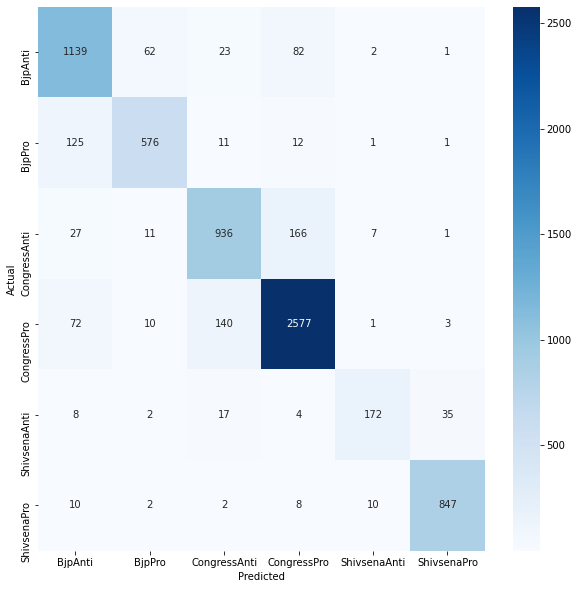

(0.8786906076112855, 0.8474175802661469, 0.8611781124084743, None)


In [52]:
# Linear Support Vector classifier model
model_svc = LinearSVC()
model_svc.fit(X_train, y_train)
y_pred = model_svc.predict(X_test)
display_result(y_test, y_pred)

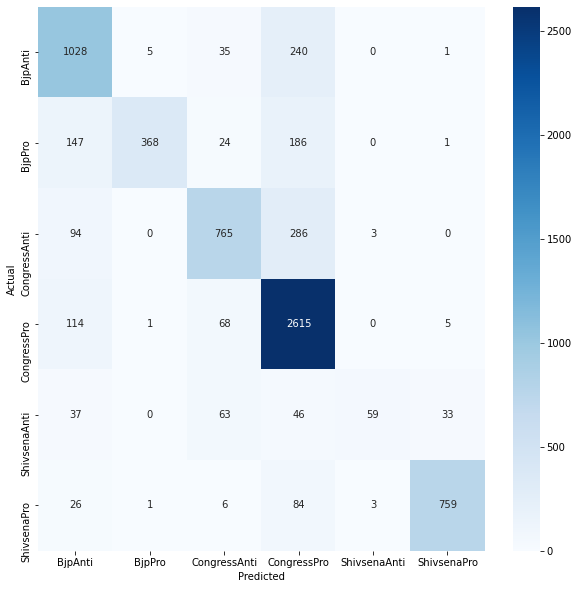

(0.8503952931907638, 0.667150844446097, 0.7116292644930308, None)


In [53]:
# Multinomial Naive Bayes classifier model
model_mnb = MultinomialNB()
model_mnb.fit(X_train, y_train)
y_pred = model_mnb.predict(X_test)
display_result(y_test, y_pred)

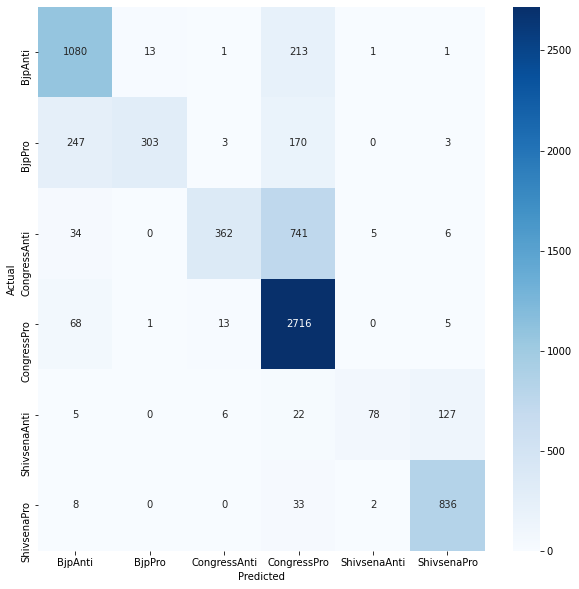

(0.8506903644747527, 0.6342528951095011, 0.6718847831223399, None)


In [54]:
# SGD classifier model
model_sgd = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state = 0, max_iter=5, tol=None)
model_sgd.fit(X_train, y_train)
y_pred = model_sgd.predict(X_test)
display_result(y_test, y_pred)

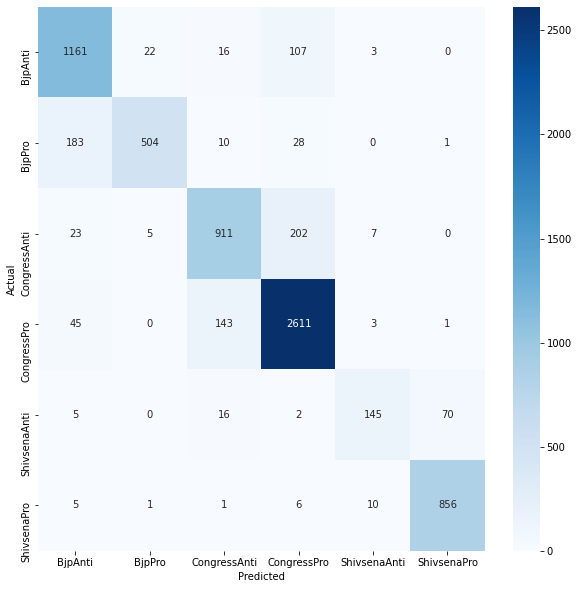

(0.8771780080886553, 0.8148808396074264, 0.8385930321908722, None)


In [55]:
# Random Forest classifier model
model_rf=RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train,y_train)
y_pred=model_rf.predict(X_test)
display_result(y_test, y_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


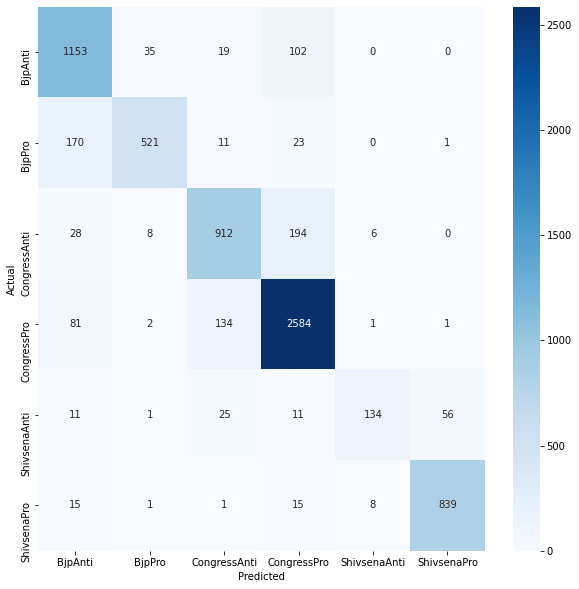

(0.8754217160655959, 0.8053782294978737, 0.8313744268471889, None)


In [56]:
# Logistic Regression classifier model
model_log = LogisticRegression()
model_log.fit(X_train,y_train)
y_pred= model_log.predict(X_test)
display_result(y_test, y_pred)

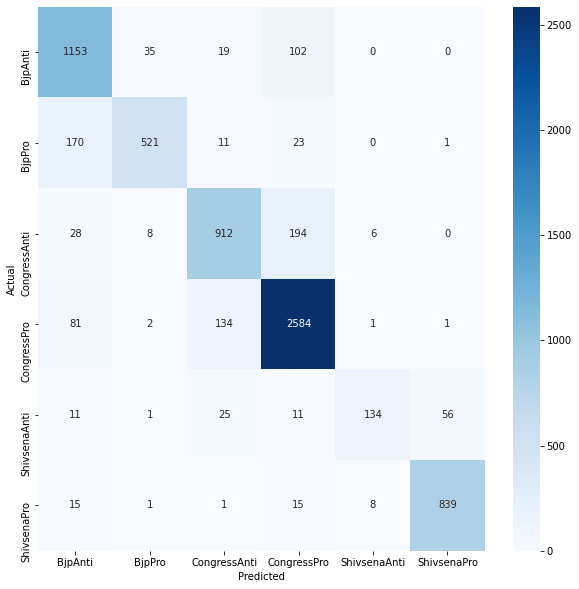

(0.8754217160655959, 0.8053782294978737, 0.8313744268471889, None)


In [57]:
# Ensemble model classifier
classifiers = [('Support Vector Classifier', model_svc), ('Random Forest', model_rf)]
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
display_result(y_test, y_pred)